### Epicurious Recipe Ratings:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Importing, Cleaning and Selecting Data:

In [2]:
data = pd.read_csv('Epicurious.csv').drop(['calories', 'protein', 'fat', 'sodium'], axis = 1)
data2 = data.drop(['title', 'rating'], 1)

In [3]:
# Trying to work with the sparse matrix:

from scipy.sparse import csr_matrix, csc_matrix
from numpy import count_nonzero

sparse_mat = csc_matrix(data2.values)
dense_mat = sparse_mat.todense()
dense_mat_transposed = dense_mat.transpose()

In [8]:
df = pd.Datadense_mat

numpy.matrixlib.defmatrix.matrix

In [10]:
# Calculating sparsity of the features:

sparse_list = []

for x in dense_mat_transposed:
    
    col_sparsity = 1-(np.count_nonzero(x))/20052  
    sparse_list.append(col_sparsity)

In [15]:
# Putting it in a DF and then sorting the values to find the columns with the least sparsity:

sparsity_df = pd.DataFrame()

sparsity_df['sparsity'] = sparse_list
sparsity_df['rating'] = data.rating.transpose()

srtd_sparsity = sparsity_df.sparsity.sort_values(ascending = True)

least_sparse_cols = srtd_sparsity[0:30]
medium_sparse_cols = srtd_sparsity[0:100]

In [17]:
least_sparse_cols

57     0.533463
453    0.581588
574    0.596649
624    0.648713
636    0.658588
240    0.668462
310    0.692051
462    0.698683
502    0.732097
654    0.755336
32     0.779922
597    0.792988
176    0.821813
171    0.840116
560    0.842859
405    0.843806
661    0.845452
204    0.849641
179    0.865101
594    0.877020
266    0.882755
306    0.884650
422    0.888390
621    0.893277
635    0.895921
544    0.898065
377    0.900509
228    0.902354
634    0.907690
305    0.910682
Name: sparsity, dtype: float64

In [6]:
# Isolating the least and mildly sparse columns into new dfs:

keys = least_sparse_cols.keys()
keys2 = medium_sparse_cols.keys()

data3 = pd.DataFrame()
data3 = data.iloc[:, keys]
data3 = data3.join(data.rating, how = 'outer')

data4 = pd.DataFrame()
data4 = data.iloc[:, keys2]
data4 = data4.join(data.rating, how = 'outer')

#### Preliminary Visualizations and Feature Engineering:

> Based on these correlation/heatmaps, it doesn't look like there are is a lot of meaningful correlation, but we'll go ahead and engineer our binary output column (i.e. the rating column) to see if that has any effect:

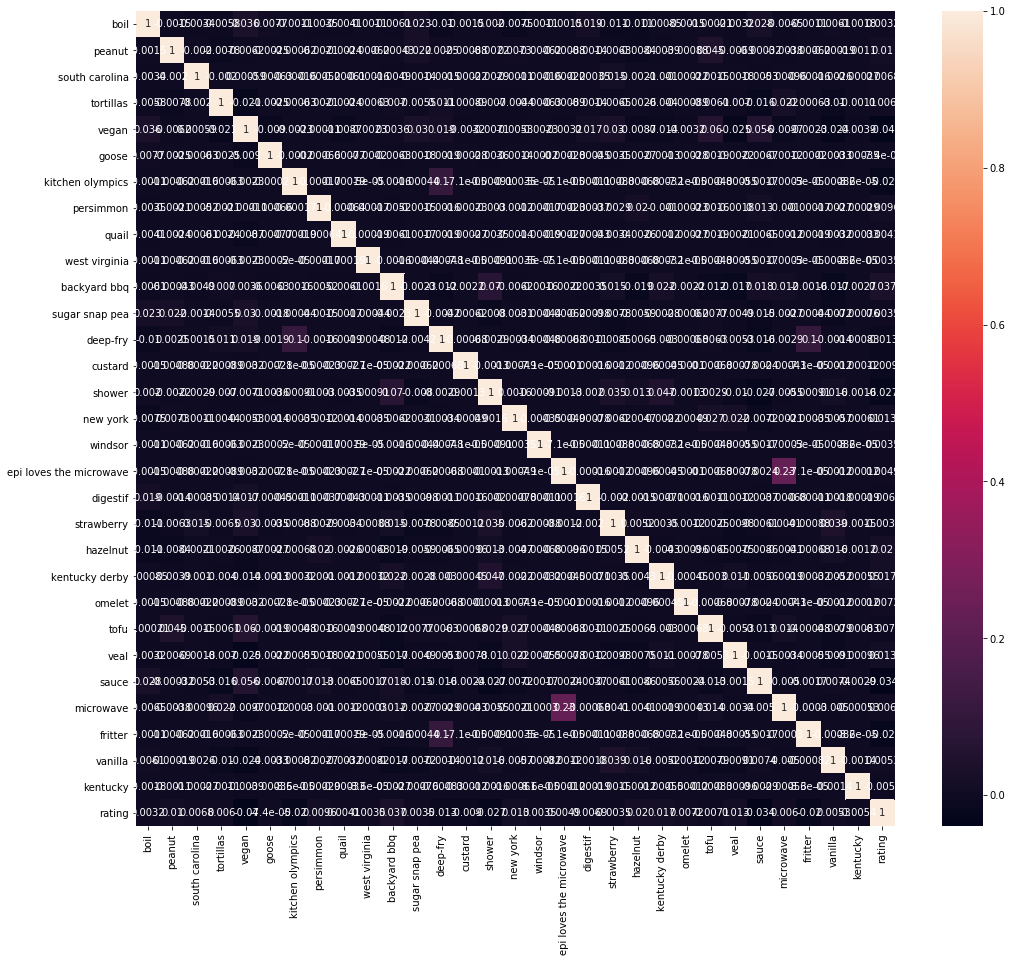

In [7]:
f, ax = plt.subplots(figsize = (17, 15))
sns.heatmap(data3.corr(), annot = True)

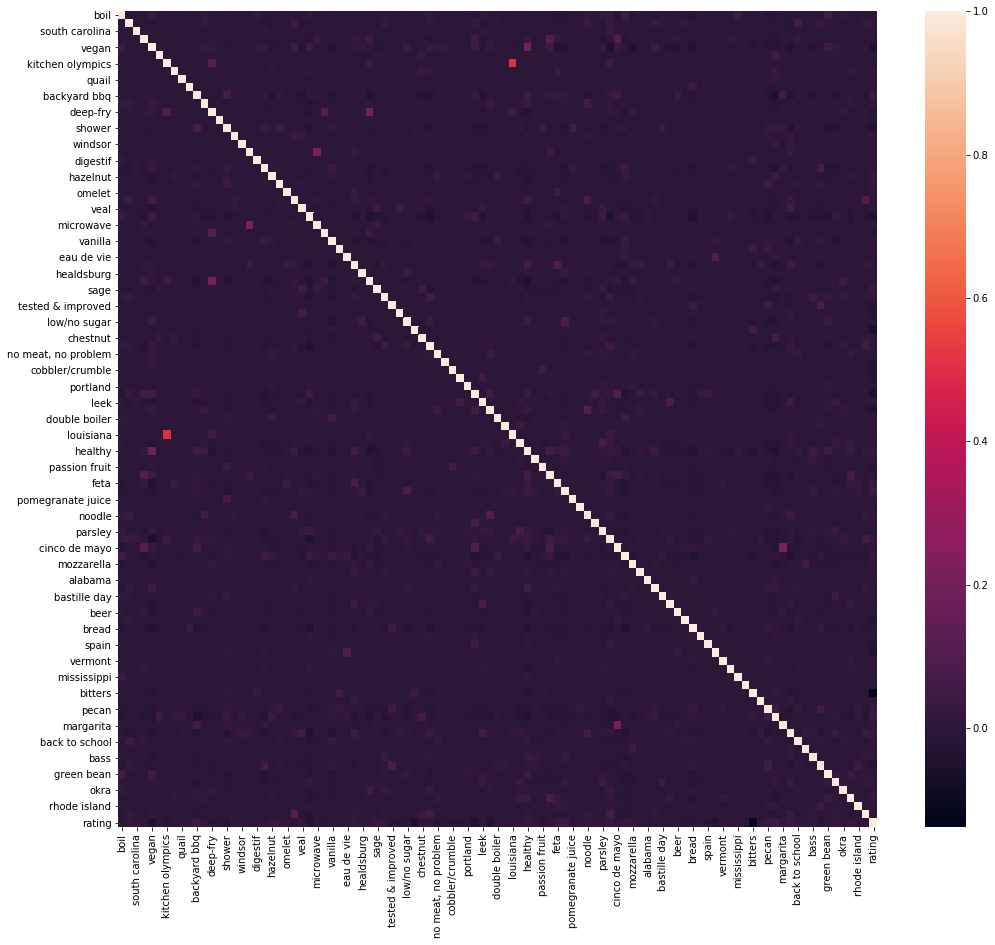

In [8]:
f, ax = plt.subplots(figsize = (17, 15))
sns.heatmap(data4.corr())

In [9]:
# Dividing our binary data at a rating of 5 to start out with:
data3.loc[data['rating'] >= 4, 'binary_rating'] = 1
data3.loc[data['rating'] < 4, 'binary_rating'] = 0
data4.loc[data['rating'] >= 4, 'binary_rating'] = 1
data4.loc[data['rating'] < 4, 'binary_rating'] = 0

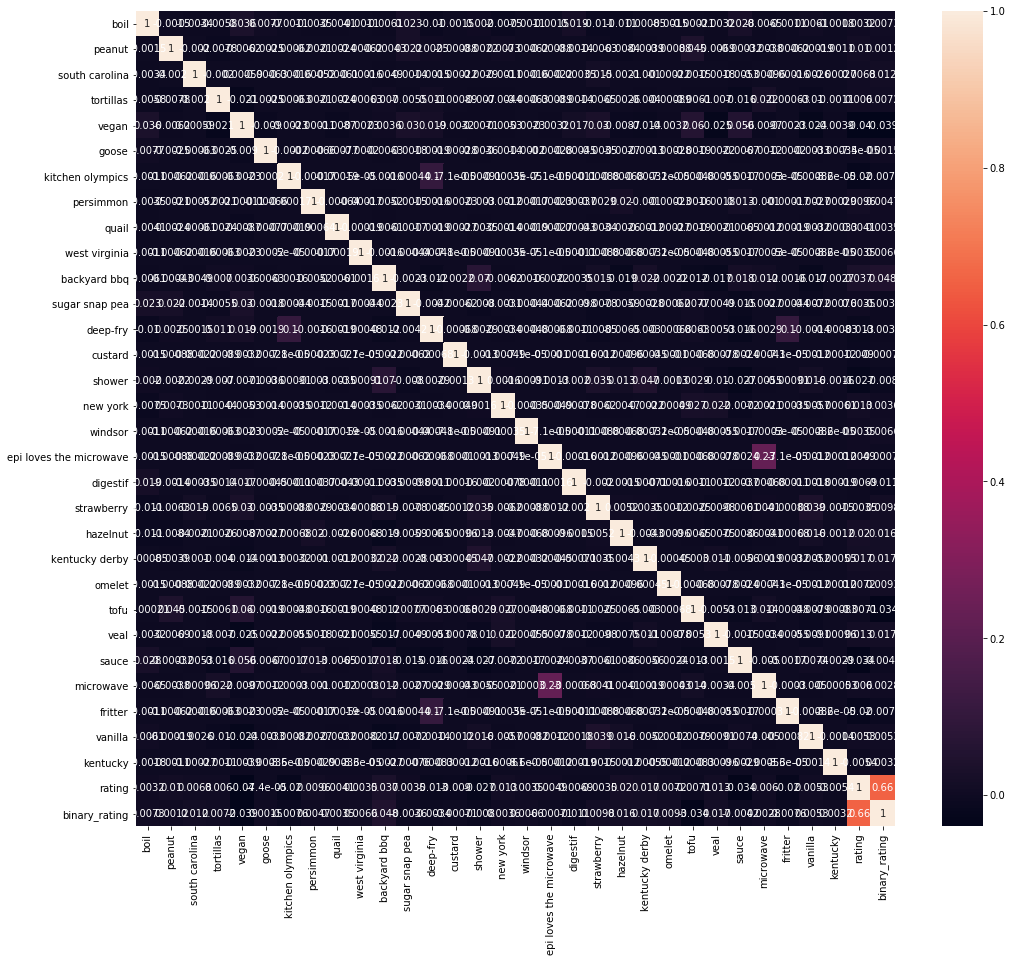

In [10]:
f, ax = plt.subplots(figsize = (17, 15))
sns.heatmap(data3.corr(), annot = True)

In [20]:
data.corr().binary_rating

pandas.core.frame.DataFrame

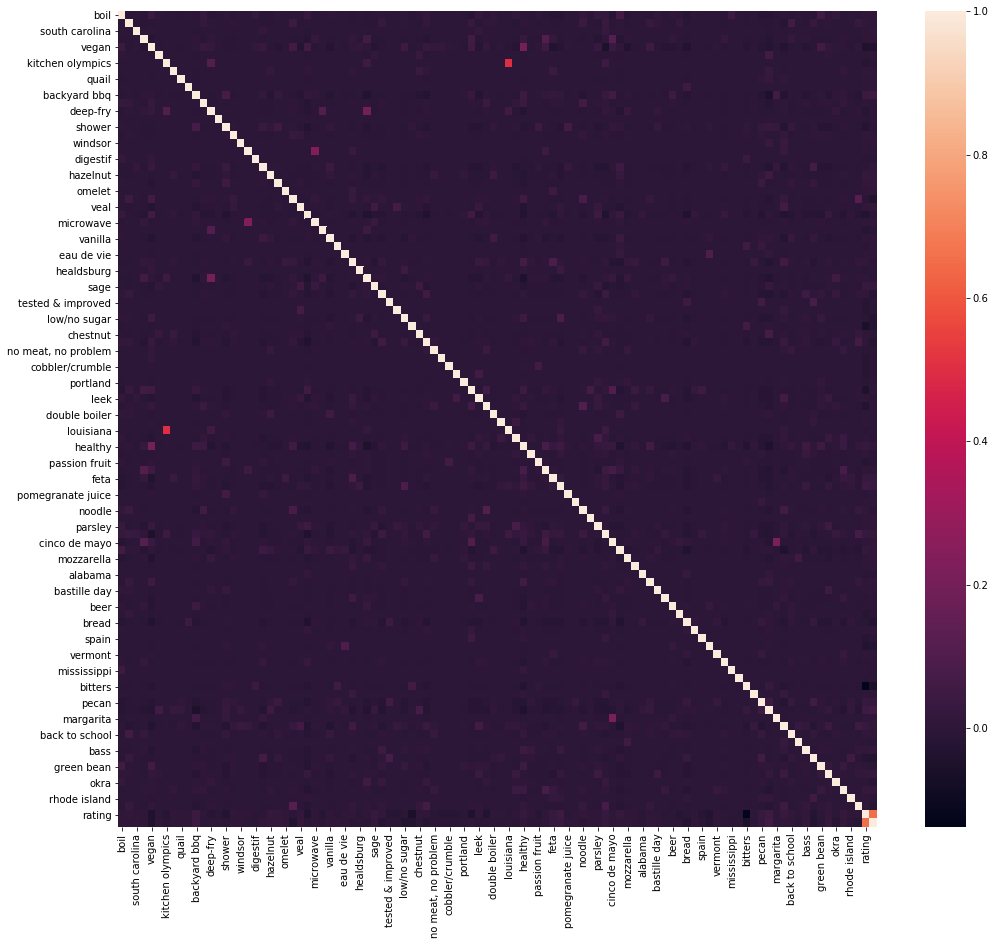

In [11]:
f, ax = plt.subplots(figsize = (17, 15))
sns.heatmap(data4.corr())

In [12]:
print("Value Counts for Data3: {}".format(data3.rating.value_counts()))
print("Value Counts for our Binary Column: \n {}".format(data3.binary_rating.value_counts()))

Value Counts for Data3: 4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64
Value Counts for our Binary Column: 
 1.0    10738
0.0     9314
Name: binary_rating, dtype: int64


In [13]:
print(data3.rating.describe())

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64


> While this is not much correlation at all, hopefully the sparse nature of the dataset will allow us to gain some prediction with the SVC Classifier. Based on the description of the columns, you can see that 50% of the data is rated at 4.375 or higher.

> Based on these correlation maps, you can see that there is definitely a bias here: people who have choosen these recipes are more than likely to give them a rating of four or five. People tend not to choose recipes that they believe they will not like.  Given that they have most-likely choosen a recipe which seemed good in the first place, there is a distinct head-start towards a positive rating.  This would explain why the single elements of food are not necessarily the greatest indicator of a positive rating, but the fact that the recipe was selected in the first place is significantly more indicative.

> A way to avoid such a bias would be to distribute the recipes, and especially the foods, to people who haven't necessarily choosen them on the internet. That way, people would be rating a recipe that they had not choosen themselves, but one place in front of them (relatively) randomly. 

> Given that our binary classes are diveded fairly evenly, we don't have to worry about class imbalance here - our main concern is the lack of correlation amongst the features and the outcome variable.

#### Splitting our Training and Test Sets:

In [14]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

X = data3.drop(['rating', 'binary_rating'], 1)
y = data3.binary_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### Trying the First Classification Models:

##### First SVC - Predicting Rating:

In [15]:
from sklearn.svm import SVC

svc_1 = SVC(kernel = 'linear')
svc_1.fit(X_train, y_train)

y_pred_ = svc_1.predict(X_test)

svc_1_cfmat = confusion_matrix(y_test, y_pred_, labels = [0, 1])
svc_1_cvscores = cross_val_score(svc_1, X, y, cv = 10)
svc_1_trainscore = svc_1.score(X_train, y_train)
svc_1_testscore = svc_1.score(X_test, y_test)

In [16]:
print("The coefficients are: \n {}".format(svc_1.coef_))

The coefficients are: 
 [[ 1.98437517e-04  0.00000000e+00  0.00000000e+00 -1.09574432e-05
  -1.99962717e+00  0.00000000e+00 -1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.50073041e-05 -1.74387656e-04
  -3.04903677e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00  0.00000000e+00
  -2.73653509e-04  0.00000000e+00  0.00000000e+00 -2.00000000e+00
   0.00000000e+00 -4.59647473e-05  0.00000000e+00 -1.00000000e+00
  -2.22044605e-15  0.00000000e+00]]


In [17]:
print("The CV Scores are: \n {}".format(svc_1_cvscores))

The CV Scores are: 
 [0.53838485 0.54187438 0.5448654  0.54586241 0.54164589 0.53466334
 0.53366584 0.54563591 0.54041916 0.54341317]


In [18]:
print("The Mean and STD of the CV Scores are:\n Mean:{}. STD: {}.".format(svc_1_cvscores.mean(), 
                                                                          svc_1_cvscores.std()))
print("The Training score is: {}".format(svc_1_trainscore))
print("The Test score is: {}".format(svc_1_testscore))
print(svc_1_cfmat)

The Mean and STD of the CV Scores are:
 Mean:0.541043034678127. STD: 0.004101003213791337.
The Training score is: 0.5424225422355214
The Test score is: 0.5387683869359262
[[ 177 1681]
 [ 169 1984]]


> These scores are significantly better than the ones in the guided example, but still not where we would want if it was something we were trying to predict out in the wild. Below, we will try a bit more to get a better score:

##### Second SVC:

> Here, we will try the dataset above which is similar to data3, but has 20 more features (still relatively significant according to our sparsity calculations above).

In [19]:
X = data4.drop(['rating', 'binary_rating'], 1)
y = data4.binary_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [ ]:
svc_2 = SVC(kernel = 'linear')
svc_2.fit(X_train, y_train)

y_pred_ = svc_2.predict(X_test)

svc_2_cfmat = confusion_matrix(y_test, y_pred_, labels = [0, 1])
svc_2_cvscores = cross_val_score(svc_2, X, y, cv = 10)
svc_2_trainscore = svc_2.score(X_train, y_train)
svc_2_testscore = svc_2.score(X_test, y_test)

In [ ]:
print("The coefficients are: \n {}".format(svc_2.coef_))

In [ ]:
print("The CV Scores are: \n {}".format(svc_2_cvscores))

In [ ]:
print("The Mean and STD of the CV Scores are:\n Mean:{}. STD: {}.".format(svc_2_cvscores.mean(), 
                                                                          svc_2_cvscores.std()))
print("The Training score is: {}".format(svc_2_trainscore))
print("The Test score is: {}".format(svc_2_testscore))
print(svc_2_cfmat)

> More features created more noise. This was worse given the cv scores, confusion_matrix and higher variation in scoring.  

##### Third SVC: 

> Combining the first 15 columns in our sparsity list (i.e. the least sparse), with the 15 towards the end (the
most sparse) in the hopes that combining the most diverse columns will increase our score.


In [ ]:
keysA = srtd_sparsity[0:15].keys()
keysB = srtd_sparsity[659:].keys()
keysC = keysA.append(keysB)

data5 = pd.DataFrame()
data5 = data.iloc[:, keysC]
data5 = data5.join(data.rating, how = 'outer')

data5.loc[data['rating'] >= 4, 'binary_rating'] = 1
data5.loc[data['rating'] < 4, 'binary_rating'] = 0

In [ ]:
X = data5.drop(['rating', 'binary_rating'], 1)
y = data5.binary_rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [ ]:
svc_3 = SVC(kernel = 'linear')
svc_3.fit(X_train, y_train)

y_pred_ = svc_3.predict(X_test)

svc_3_cfmat = confusion_matrix(y_test, y_pred_, labels = [0, 1])
svc_3_cvscores = cross_val_score(svc_3, X, y, cv = 10)
svc_3_trainscore = svc_3.score(X_train, y_train)
svc_3_testscore = svc_3.score(X_test, y_test)

In [ ]:
print("The coefficients are: \n {}".format(svc_3.coef_))

In [ ]:
print("The CV Scores are: \n {}".format(svc_3_cvscores))

In [ ]:
print("The Mean and STD of the CV Scores are:\n Mean:{}. STD: {}.".format(svc_3_cvscores.mean(), 
                                                                          svc_3_cvscores.std()))
print("The Training score is: {}".format(svc_3_trainscore))
print("The Test score is: {}".format(svc_3_testscore))
print(svc_3_cfmat)

> Here, you can see are scores are relatively similar, although our predictions for lower scores have gone up and
our predictions for higher scores have gone down. 